# Trans data mean process

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
import os

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
data_raw = pd.read_excel("~/Documents/phd/tomato_metabolic/作图2.19/热图/energy热图2.xlsx", sheet_name=0, index_col=0)
data = data_raw.copy()
#del data["ID"]
#del data["Family"]

## meta data

In [6]:
data_meta = pd.DataFrame(data.columns)
data_meta.columns = ["sample"]
data_meta.index = data_meta["sample"]
data_meta['condition_HAG'] = data_meta["sample"].str.split("h-", expand=True)[0]


import re
def get_condition(series):
    return re.split("(\d+)", series['condition_HAG'])[0]

def get_HAG(series):
    return re.split("(\d+)", series['condition_HAG'])[1]

data_meta['Condition'] = data_meta.apply(get_condition, axis=1)
data_meta['HAG'] = data_meta.apply(get_HAG, axis=1)
data_meta = data_meta[['condition_HAG', 'Condition', 'HAG']]
data_meta.head(2)

,condition_HAG,Condition,HAG
sample,,,
C0h-1_fpkm,C0,C,0
C0h-2_fpkm,C0,C,0


## data

In [7]:
data['gene'] = data.index
data = data.melt(id_vars=['gene'])
data['condition_HAG'] = data_meta.loc[data['variable'], "condition_HAG"].to_list()
data = data.groupby(['gene', 'condition_HAG']).mean()["value"].reset_index()
data = pd.crosstab(data['gene'], data['condition_HAG'], aggfunc='max',values=data['value'].to_list())

<ipython-input-7-ab64c61407dd>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['gene', 'condition_HAG']).mean()["value"].reset_index()


In [8]:
data_meta2 = pd.DataFrame(data.columns)
data_meta2.columns = ["sample"]

def get_condition2(series):
    return re.split("(\d+)", series['sample'])[0]

def get_HAG2(series):
    return re.split("(\d+)", series['sample'])[1]

data_meta2['Condition'] = data_meta2.apply(get_condition2, axis=1)
data_meta2['HAG'] = data_meta2.apply(get_HAG2, axis=1)
data_meta2['HAG'] = data_meta2['HAG'].astype(int)
data_meta2 = data_meta2.sort_values(['Condition', 'HAG'])

data = data.loc[data.index, data_meta2['sample']]

In [9]:
os.chdir("/Users/yuanzan/Documents/github/seqyuan/tomato_graft_omics/data/heatmap219")

In [10]:
data.to_csv('energy_2_mean_FPkM.csv', sep="\t")
data_meta2.to_csv('energy_2_mean_FPkM_meta.csv', sep="\t")

# R code for heatmap

In [2]:
library(UpSetR)
library(readxl)
library(ggplot2)
library(clusterProfiler)
library(ClusterGVis)
library(Mfuzz)
library(AnnotationHub) 
library(biomaRt)
library(ComplexHeatmap)
library(dplyr)
library(stringr)
library(circlize)
library(pheatmap)

In [3]:
setwd('/Users/yuanzan/Documents/github/seqyuan/tomato_graft_omics/data/heatmap219')

In [5]:
df <- read.table("energy_2_mean_FPkM.csv", sep="\t", header=TRUE, row.names=1)
df_meta <- read.table("energy_2_mean_FPkM_meta.csv", sep="\t", header=TRUE, row.names=2)

df_meta <- df_meta[,c('Condition', 'HAG')]
df_meta$Condition <- factor(df_meta$Condition, levels=c('C', 'D', 'CC', 'DD', 'CD'))

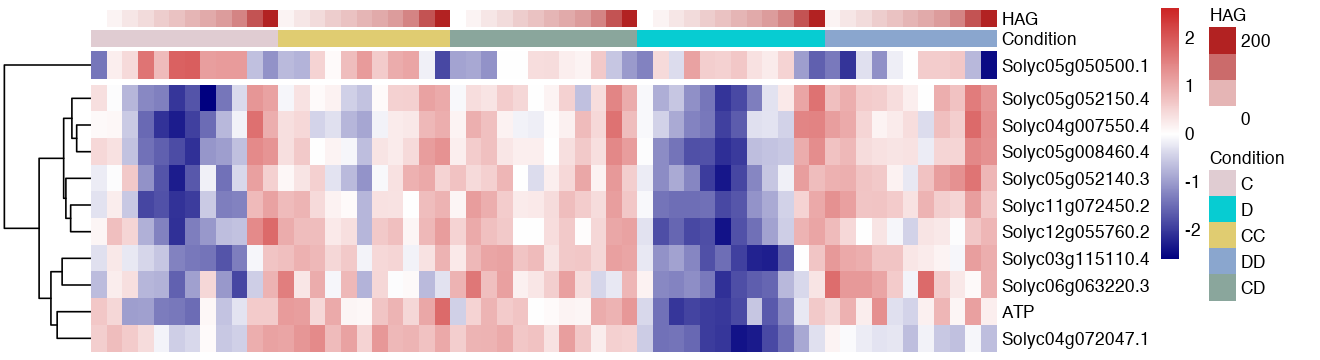

In [17]:
options(repr.plot.width=11, repr.plot.height=3)
#pdf('heatmap1.pdf', width = 12, height=10)

ann_colors = list(
  HAG = c("white", "firebrick"),
  Condition = c(C = "#E0CCD2", D = "#07CCD2", CC = "#E0CC71", DD = "#8AA6CE", CD = "#8AA69C")
)

pheatmap(log2(df+0.01), 
         annotation_col = df_meta, 
         #annotation_row = gene_meta, 
         annotation_colors=ann_colors, 
         border_color=NA,
         cluster_rows=TRUE, cluster_cols=FALSE, 
         show_rownames=TRUE, show_colnames=FALSE,
         cutree_rows =2,
         color = colorRampPalette(c("navy","white","firebrick3"))(256),
         #color = colorRampPalette(c("blue", "white", "yellow"))(256),
         scale = "row", 
         width=11, height=3)#, filename="energy_2_heatmap.pdf")

#dev.off()